In [ ]:
!pip install pennylane
!pip install qiskit
!pip install qiskit_nature

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.3/241.3 KB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install pyscf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 25.7 MB/s eta 0:00:00


In [ ]:
import json
import pennylane as qml
from pennylane import qchem 
import pennylane.numpy as np
import matplotlib.pyplot as plt
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.mappers.second_quantization import BravyiKitaevMapper, JordanWignerMapper, ParityMapper
from qiskit_nature.drivers import Molecule
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.algorithms import GroundStateEigensolver, VQEUCCFactory
from qiskit import Aer
from qiskit.algorithms.optimizers import SLSQP
from qiskit_nature.circuit.library import UCC

import warnings
warnings.filterwarnings('ignore')

<ipython-input-3-345fc2c37443>:12: NatureDeprecationWarning: The qiskit_nature.algorithms.excited_state_solvers package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_nature.second_q.algorithms.excited_state_solvers package.
  from qiskit_nature.algorithms import GroundStateEigensolver, VQEUCCFactory
<ipython-input-3-345fc2c37443>:12: NatureDeprecationWarning: The qiskit_nature.algorithms.pes_sampler package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release . Please refer to 'https://github.com/Qiskit/qiskit-nature/issues/750' for additional information regarding 'extrapolators'.
  from qiskit_nature.algorithms import GroundStateEigensolver, VQEUCCFactory


In [ ]:
r=1.7
hydrogen_t = [["H", [-r, 0.0, 0.0]], 
              ["Be", [0.0, 0.0, 0.0]], 
              ["H", [r, 0.0, 0.0]]]
                  
h3p = Molecule(
    geometry=  hydrogen_t,
    multiplicity=1, 
    charge=0, 
)

driver = ElectronicStructureMoleculeDriver(h3p, basis="sto-3g", driver_type=ElectronicStructureDriverType.PYSCF) 

properties = driver.run()

In [ ]:
num_alpha_electrons = properties.get_property('ParticleNumber').num_alpha
num_beta_electrons = properties.get_property('ParticleNumber').num_beta
num_spin_orbitals = int(properties.get_property('ParticleNumber').num_spin_orbitals)

nuclear_rep_energy = properties.get_property('ElectronicEnergy').nuclear_repulsion_energy
print("number of alpha electrons: " , num_alpha_electrons)
print("number of beta electrons: " , num_beta_electrons)
print("number of spin orbitals: " , num_spin_orbitals)
print("nuclear repulsion energy: " , nuclear_rep_energy)

number of alpha electrons:  3
number of beta electrons:  3
number of spin orbitals:  14
nuclear repulsion energy:  2.6458860546


We set the number of active orbitals to 6 and the number of active electron to 4, because it took too long to get the exact result when we use  7 orbitals and 6 electrons. 

In [ ]:
PN_property = properties.get_property("ParticleNumber")

transformer = ActiveSpaceTransformer(
    num_electrons=4, 
    num_molecular_orbitals=6, #We set 6 active orbitals since 7 takes too long to run
)

problem_reduced = ElectronicStructureProblem(driver, transformers=[transformer]) 

second_q_ops_reduced = problem_reduced.second_q_ops()

In [ ]:
mapper = JordanWignerMapper()

converter = QubitConverter(mapper)

qubit_op = converter.convert(second_q_ops_reduced["ElectronicEnergy"])

# Get the exact solution from qiskit.

In [ ]:
vqe_factory = VQEUCCFactory( 
    quantum_instance=Aer.get_backend("aer_simulator_statevector"),
    optimizer=SLSQP(),
    ansatz=UCC(excitations='sd')
) 

from qiskit.algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()

solver = GroundStateEigensolver(converter, vqe_factory)  # Define Numpy
real_solution_t = solver.solve(problem_reduced).total_energies[0]    
print('Reference energy : ', real_solution_t)

Reference energy :  (-15.527759639497551+0j)


In [ ]:
def hydrogen_hamiltonian(coordinates, charge, active_orb=6, num_e=4):
    """Calculates the qubit Hamiltonian of the hydrogen molecule.
    
    Args:
        coordinates (list(float)): Cartesian coordinates of each hydrogen molecule.
        charge (int): The electric charge given to the hydrogen molecule.

    Returns:
        (qml.Hamiltonian): A PennyLane Hamiltonian.
    """
    return qml.qchem.molecular_hamiltonian(
        [ "H","Be", "H"], coordinates, charge, basis="sto-3g",active_electrons=num_e, active_orbitals=active_orb
    )[0]

def num_electrons(charge):
    """The total number of electrons in the hydrogen molecule.
    
    Args:
        charge (int): The electric charge given to the hydrogen molecule.

    Returns: 
        (int): The number of electrons.
    """
    return 4-charge

def hf(electrons, num_qubits):
    """Calculates the Hartree-Fock state of the hydrogen molecule.
    
    Args:
        electrons (int): The number of electrons in the hydrogen molecule.
        num_qubits (int): The number of qubits needed to represent the hydrogen molecule Hamiltonian.

    Returns:
        (numpy.tensor): The HF state.
    """
    # Put your solution here #
    return qml.qchem.hf_state(electrons=electrons, orbitals=num_qubits)

In [ ]:
def BeH2_data(r,threshold, selection=True):
    a0=0.529177210903
    coordinates=[ 0.0, 0.0, -r/a0, 0.0, 0.0, 0.0, 0.0, 0.0, r/a0] # in atomic unit
    charge=0
    hamiltonian = hydrogen_hamiltonian(np.array(coordinates), charge)

    electrons = num_electrons(charge)
    num_qubits = len(hamiltonian.wires)

    hf_state = hf(electrons, num_qubits)
    # singles and doubles are used to make the AllSinglesDoubles template
    singles, doubles = qml.qchem.excitations(electrons, num_qubits)

    dev = qml.device("default.qubit", wires=num_qubits)
    @qml.qnode(dev)
    def circuit_1(params, excitations):
        qml.BasisState(hf_state, wires=range(num_qubits))

        for i, excitation in enumerate(excitations):
            if len(excitation) == 4:
                qml.DoubleExcitation(params[i], wires=excitation)
            else:
                qml.SingleExcitation(params[i], wires=excitation)
        return qml.expval(hamiltonian )

    params = [0.0] * len(doubles)
    params=np.array(params )

    dev = qml.device("default.qubit", wires=num_qubits)
    cost_fn = qml.QNode(circuit_1, dev)
    circuit_gradient = qml.grad(cost_fn, argnum=0)
    grads_d = circuit_gradient(params, excitations=doubles)

    #for i in range(len(doubles)):
    #    print(f"Excitation : {doubles[i%len(doubles)]}, Gradient: {grads_d[i]}")

    params = [0.0] * len(singles)
    params=np.array(params )

    dev = qml.device("default.qubit", wires=num_qubits)
    cost_fn = qml.QNode(circuit_1, dev)
    circuit_gradient = qml.grad(cost_fn, argnum=0)
    grads_s = circuit_gradient(params, excitations=singles)

    #for i in range(len(singles)):
    #    print(f"Excitation : {singles[i%len(singles)]}, Gradient: {grads_s[i]}")

    doubles_select = [(doubles*2)[i] for i in range(len(doubles)) if abs(grads_d[i]) > threshold]
    singles_select = [(singles*2)[i] for i in range(len(singles)) if abs(grads_s[i]) > threshold]

    if selection==True:
        return doubles_select, singles_select, num_qubits, hf_state, hamiltonian
    elif selection==False:
        return doubles, singles, num_qubits, hf_state, hamiltonian

# Basic fixed layer VQE

The basic fixed layer VQE is composed of all single qubit excitation gates[1] and double qubit excitation gates[2].

[1] https://docs.pennylane.ai/en/stable/code/api/pennylane.SingleExcitation.html

[2] https://docs.pennylane.ai/en/stable/code/api/pennylane.DoubleExcitation.html

(Note: the circuit depth here only counts single qubit excitations and double qubit excitations without converting them into native gates in quantum computing.)

In [ ]:
def run_VQE(r):
    """Performs a VQE routine for the given hydrogen molecule.

    Args:
        coordinates (list(float)): Cartesian coordinates of each hydrogen molecule.
        charge (int): The electric charge given to the hydrogen molecule.:

    Returns:
        (float): The expectation value of the hydrogen Hamiltonian.
    """
    doubles, singles, num_qubits, hf_state, hamiltonian=BeH2_data(r,1e-5, selection=False)
    print("The basic vqe uses ",len(doubles)+ len(singles)," parameters")
    print("The basic vqe uses ",len(doubles)*13 + len(singles)*2," cnot gates")
    print("The basic vqe uses ",len(doubles)*34 + len(singles)*10," gates")
    #print("The original vqe use ",len(doubles + singles)," parameters")
    dev = qml.device("default.qubit", wires=num_qubits)
    @qml.qnode(dev)
    def cost(weights):
        """A circuit with tunable parameters/weights that measures the expectation value of the hydrogen Hamiltonian.
        
        Args:
            weights (numpy.array): An array of tunable parameters.

        Returns:
            (float): The expectation value of the hydrogen Hamiltonian.
            
        """
        #state=np.array([0]*(num_qubits//2)+[1]*(num_qubits//2))
        qml.BasisState(hf_state, wires=list(range(num_qubits)))

        for i in range(len(singles)):
            #for j in range(E_len):
            qml.SingleExcitation(weights[i+len(doubles)], wires=singles[i])

        for i in range(len(doubles)):
            qml.DoubleExcitation(weights[i], wires=doubles[i])

        
        return qml.expval(hamiltonian)
    
    #np.random.seed = 1234
    weights =np.zeros(len(doubles + singles), requires_grad=True)
    #weights = np.random.normal(0, 2*np.pi, len(doubles)+len(singles), requires_grad=True)
    #weights =np.concatenate((params, params_d))
    #opt = qml.GradientDescentOptimizer(stepsize=0.5)
    opt = qml.AdamOptimizer(stepsize=0.05)
    #eta = 0.05
    #opt = qml.QNGOptimizer(0.05)

    i=0
    iter=[]
    cost_val=[]
    Lowest_E=0
    best_weights=0
    for _ in range(100):
        weights = opt.step(cost, weights)
        iter.append(i)
        cost_fn=cost(weights)

        if Lowest_E>cost_fn:
            Lowest_E=cost_fn
            best_weights=weights
        cost_val.append(cost_fn)
        print('iter:',i,' cost_fn:',cost_fn)
        i=i+1

    return Lowest_E, iter, cost_val, best_weights

In [ ]:
Lowest_E, iter, cost_val, best_weights=run_VQE(r)

The basic vqe uses  92  parameters
The basic vqe uses  1020  cnot gates
The basic vqe uses  2744  gates
iter: 0  cost_fn: -15.500365087575855
iter: 1  cost_fn: -15.516041543452497
iter: 2  cost_fn: -15.523293972616555
iter: 3  cost_fn: -15.523024937644562
iter: 4  cost_fn: -15.520198816357777
iter: 5  cost_fn: -15.517930739638686
iter: 6  cost_fn: -15.517304199780671
iter: 7  cost_fn: -15.51826416371182
iter: 8  cost_fn: -15.520038629819455
iter: 9  cost_fn: -15.521682087098602
iter: 10  cost_fn: -15.522774281856913
iter: 11  cost_fn: -15.523416095050774
iter: 12  cost_fn: -15.523905037980633
iter: 13  cost_fn: -15.52445386723022
iter: 14  cost_fn: -15.52505567038314
iter: 15  cost_fn: -15.525523950960503
iter: 16  cost_fn: -15.525722988725972
iter: 17  cost_fn: -15.525701990847992
iter: 18  cost_fn: -15.525587483883314
iter: 19  cost_fn: -15.525462785642718
iter: 20  cost_fn: -15.525403802713416
iter: 21  cost_fn: -15.525518150360762
iter: 22  cost_fn: -15.525873505933726
iter: 23  co

# Adaptive circuit

Inspired by the idea in paper [3], pennylane people develop an method to reduce number of gates to train before running vqe. The method in Pennylane document [4] is to get rid of the gate with small gradient before executing vqe. The number of gates and parameters are significantly reduced. This way is useful for hardware to get rid of redundant gates since NISQ device have a lot of gate noise and short lifetime of qubits.

[3] https://www.nature.com/articles/s41467-019-10988-2 

[4] https://pennylane.ai/qml/demos/tutorial_adaptive_circuits.html

In [ ]:
def run_adaptive_cir_VQE(r):
    """Performs a VQE routine for the given hydrogen molecule.

    Args:
        coordinates (list(float)): Cartesian coordinates of each hydrogen molecule.
        charge (int): The electric charge given to the hydrogen molecule.:

    Returns:
        (float): The expectation value of the hydrogen Hamiltonian.
    """

    doubles_select, singles_select, num_qubits, hf_state, hamiltonian=BeH2_data(r,1e-5, selection=True)

    print("The adaptive circuit + vqe uses ",len(doubles_select)+ len(singles_select)," parameters")
    #print(num_qubits,len(singles),len( doubles))
    print("The adaptive circuit + vqe uses ",len(doubles_select)*13 + len(singles_select)*2," cnot gates")
    print("The adaptive circuit + vqe uses ",len(doubles_select)*34 + len(singles_select)*10," gates")

    dev = qml.device("default.qubit", wires=num_qubits)

    @qml.qnode(dev)
    def cost(weights):
        """A circuit with tunable parameters/weights that measures the expectation value of the hydrogen Hamiltonian.
        
        Args:
            weights (numpy.array): An array of tunable parameters.

        Returns:
            (float): The expectation value of the hydrogen Hamiltonian.
            
        """
        #state=np.array([0]*(num_qubits//2)+[1]*(num_qubits//2))
        qml.BasisState(hf_state, wires=list(range(num_qubits)))

        for i in range(len(doubles_select)):
            qml.DoubleExcitation(weights[i], wires=doubles_select[i])

        for i in range(len(singles_select)):
            #for j in range(E_len):
            qml.SingleExcitation(weights[i+len(doubles_select)], wires=singles_select[i])
        
        return qml.expval(hamiltonian)
    
    #np.random.seed = 1234
    weights =np.zeros(len(doubles_select + singles_select), requires_grad=True)
    opt = qml.AdamOptimizer(stepsize=0.05)

    i=0
    iter=[]
    cost_val=[]
    Lowest_E=0
    best_weights=0
    for _ in range(100):
        weights = opt.step(cost, weights)
        cost_fn=cost(weights)
        if Lowest_E>cost_fn:
            Lowest_E=cost_fn
            best_weights=weights
        cost_val.append(cost_fn)
        iter.append(i)
        #cost_val.append(cost(weights))
        print('iter:',i,' cost_fn:',cost_fn)
        i=i+1

    return Lowest_E, iter, cost_val, best_weights

In [ ]:
Lowest_E_a, iter, cost_val_a, best_weights_a=run_adaptive_cir_VQE(r)

The adaptive circuit + vqe uses  14  parameters
The adaptive circuit + vqe uses  182  cnot gates
The adaptive circuit + vqe uses  476  gates
iter: 0  cost_fn: -15.500364616985351
iter: 1  cost_fn: -15.516528830940857
iter: 2  cost_fn: -15.523253169035174
iter: 3  cost_fn: -15.523265892353956
iter: 4  cost_fn: -15.52038230076996
iter: 5  cost_fn: -15.517814739079009
iter: 6  cost_fn: -15.517128793691477
iter: 7  cost_fn: -15.518107922004761
iter: 8  cost_fn: -15.519788415206406
iter: 9  cost_fn: -15.521340642493776
iter: 10  cost_fn: -15.52242627265364
iter: 11  cost_fn: -15.523148619966483
iter: 12  cost_fn: -15.523748211717114
iter: 13  cost_fn: -15.524344900425739
iter: 14  cost_fn: -15.524904998649738
iter: 15  cost_fn: -15.525338147329403
iter: 16  cost_fn: -15.525577037075795
iter: 17  cost_fn: -15.525604060556548
iter: 18  cost_fn: -15.525461787201438
iter: 19  cost_fn: -15.525259686759593
iter: 20  cost_fn: -15.525154114084838
iter: 21  cost_fn: -15.525275849968596
iter: 22  cos

# TETRIS adaptive circuit
In 2022 September, Virginia Tech's group published the improved version of ADAPT-VQE [5]. It is called TETRIS-ADAPT-VQE. In order to stack the gate well without many idle qubits, they not only add the gate with the latgest gradient but also add the gates with second or third largest gradient but not overlaped with others in the apdative itersion. Inspired by this paper and Katharine's talk of the qhack, we also modified adaptive circuit in Pennylane document. First of all, we also delete some gates with small gradient. Then, we sorted the remaining gate according to their gradient. We try to put them on the circuits without too many overlape among the gates. We call this method as TETRIS adaptive circuit.

[5] https://arxiv.org/abs/2209.10562

In [ ]:
def run_TETRIS_adaptive_cir_VQE(r):
    
    doubles_select, singles_select, num_qubits, hf_state, hamiltonian=BeH2_data(r,1e-5, selection=True)
    doubles, singles, _, _, _=BeH2_data(r,1e-5, selection=False)

    print("The TETRIS adaptive VQE use ",len(doubles_select) + len(singles_select)," parameters")
    print("The TETRIS adaptive circuit use ",len(doubles_select)*13 + len(singles_select)*2," cnot gates")
    print("The TETRIS adaptive circuit use ",len(doubles_select)*34 + len(singles_select)*10," gates")

    dev = qml.device("default.qubit", wires=num_qubits)
    @qml.qnode(dev)
    def circuit_1(params, excitations):
        qml.BasisState(hf_state, wires=range(num_qubits))

        for i, excitation in enumerate(excitations):
            if len(excitation) == 4:
                qml.DoubleExcitation(params[i], wires=excitation)
            else:
                qml.SingleExcitation(params[i], wires=excitation)
        return qml.expval(hamiltonian )

    params = [0.0] * len(doubles+singles)
    params=np.array(params )

    dev = qml.device("default.qubit", wires=num_qubits)
    cost_fn = qml.QNode(circuit_1, dev)
    circuit_gradient = qml.grad(cost_fn, argnum=0)
    grads = circuit_gradient(params, excitations=doubles+singles)

    op_pool=doubles+singles
    new_op_pool=[op_pool[idx] for idx in range(len(grads)) if abs(grads[idx]) >1e-5]
    new_grads=[grads[idx] for idx in range(len(grads)) if abs(grads[idx]) > 1e-5]
              

    Stacked_op_pool=[]

    indx=np.argsort(np.abs(new_grads))
    sorted_op_pool=[new_op_pool[idx] for idx in indx]

    Stacked_op_pool=[]
    q_layer=[]     
    ind_left=[]       
    while len(sorted_op_pool) !=0:
        for idx, op in enumerate(sorted_op_pool):
            if Stacked_op_pool==[]:
                Stacked_op_pool.append(op)
                q_layer=q_layer+op
            else:
                Stack=True
                for k in op:
                    if k in q_layer:
                        Stack=False
                        ind_left.append(idx)
                        break
                if Stack:
                    Stacked_op_pool.append(op)
                    q_layer=q_layer+op
        sorted_op_pool=[sorted_op_pool[idx] for idx in ind_left]
        q_layer=[]
        ind_left=[]
    dev = qml.device("default.qubit", wires=num_qubits)
    @qml.qnode(dev)
    def cost(params, excitations):
        qml.BasisState(hf_state, wires=range(num_qubits))

        for i, excitation in enumerate(excitations):
            if len(excitation) == 4:
                qml.DoubleExcitation(params[i], wires=excitation)
            else:
                qml.SingleExcitation(params[i], wires=excitation)
        return qml.expval(hamiltonian)

    weights =np.zeros(len(Stacked_op_pool), requires_grad=True)
    opt = qml.AdamOptimizer(stepsize=0.05)

    i=0
    iter=[]
    cost_val=[]
    Lowest_E=0
    best_weights=0
    for _ in range(100):
        weights,_ = opt.step(cost, weights, Stacked_op_pool)
        cost_fn=cost(weights,Stacked_op_pool)
        if Lowest_E>cost_fn:
            Lowest_E=cost_fn
            best_weights=weights
        cost_val.append(cost_fn)
        iter.append(i)
        #cost_val.append(cost(weights))
        print('iter:',i,' cost_fn:',cost_fn)
        i=i+1

    return Lowest_E, iter, cost_val, best_weights

In [ ]:
Lowest_E_t, iter, cost_val_t, best_weights_t=run_TETRIS_adaptive_cir_VQE(r)

The TETRIS adaptive VQE use  14  parameters
The TETRIS adaptive circuit use  182  cnot gates
The TETRIS adaptive circuit use  476  gates
iter: 0  cost_fn: -15.500330773341302
iter: 1  cost_fn: -15.516475074877548
iter: 2  cost_fn: -15.523277342963096
iter: 3  cost_fn: -15.523461521401991
iter: 4  cost_fn: -15.520723258000213
iter: 5  cost_fn: -15.518186356678722
iter: 6  cost_fn: -15.517374490434019
iter: 7  cost_fn: -15.51807898291169
iter: 8  cost_fn: -15.519451726670003
iter: 9  cost_fn: -15.52081845189387
iter: 10  cost_fn: -15.521940204138433
iter: 11  cost_fn: -15.522883335195232
iter: 12  cost_fn: -15.523738307233483
iter: 13  cost_fn: -15.524491288464247
iter: 14  cost_fn: -15.52508498884163
iter: 15  cost_fn: -15.525492959074853
iter: 16  cost_fn: -15.52570728929993
iter: 17  cost_fn: -15.525715678230771
iter: 18  cost_fn: -15.525538461685354
iter: 19  cost_fn: -15.525279575370014
iter: 20  cost_fn: -15.52511466311896
iter: 21  cost_fn: -15.525191028987294
iter: 22  cost_fn: -

# Method's Comparison
We show how single qubit excitation and double qubit excitation manifested on quantum computer using the single rotation gates and cnot gates [5]. We can convert the single qubit excitation and double qubit excitation gates on the circuit to the native quantum gates. Thus, we can calculate the each method's circuit depth on the real quantum computer.

[5] https://arxiv.org/abs/2209.10562

In [ ]:

def Doublexcitation(param,wires):
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.CNOT(wires=[wires[2],wires[3]])
    qml.PauliX(wires=wires[1])
    qml.PauliX(wires=wires[3])
    qml.CNOT(wires=[wires[0],wires[2]])
    qml.RY(param/8,wires=[wires[0]])
    qml.Hadamard(wires=wires[1])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.RY(-param/8,wires=[wires[0]])
    qml.Hadamard(wires=wires[3])
    qml.CNOT(wires=[wires[0],wires[3]])
    qml.RY(param/8,wires=[wires[0]])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.RY(-param/8,wires=[wires[0]])
    qml.Hadamard(wires=wires[2])
    qml.CNOT(wires=[wires[0],wires[2]])
    qml.RY(param/8,wires=[wires[0]])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.RY(-param/8,wires=[wires[0]])
    qml.CNOT(wires=[wires[0],wires[3]])
    qml.RY(param/8,wires=[wires[0]])
    qml.Hadamard(wires=wires[3])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.RY(-param/8,wires=[wires[0]])
    qml.Hadamard(wires=wires[1])
    qml.RZ(-np.pi/2,wires=[wires[2]])
    qml.CNOT(wires=[wires[0],wires[2]])
    qml.RZ(np.pi/2,wires=[wires[0]])
    qml.RZ(-np.pi/2,wires=[wires[2]])
    qml.PauliX(wires=wires[1])
    qml.RY(-np.pi/2,wires=[wires[2]])
    qml.PauliX(wires=wires[3])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.CNOT(wires=[wires[2],wires[3]])

def SingleExcitation(param,wires):
    qml.RZ(np.pi/2,wires=[wires[0]])
    qml.RX(np.pi/2,wires=[wires[0]])
    qml.RX(np.pi/2,wires=[wires[1]])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.RX(param,wires=[wires[0]])
    qml.RZ(param,wires=[wires[1]])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.RX(-np.pi/2,wires=[wires[0]])
    qml.RX(-np.pi/2,wires=[wires[1]])
    qml.RZ(-np.pi/2,wires=[wires[0]])

In [ ]:
a0=0.529177210903
coordinates=[ 0.0, 0.0, -r/a0, 0.0, 0.0, 0.0, 0.0, 0.0, r/a0] # in atomic unit
charge=0
hamiltonian = hydrogen_hamiltonian(np.array(coordinates), charge)

electrons = num_electrons(charge)
num_qubits = len(hamiltonian.wires)

hf_state = hf(electrons, num_qubits)
# singles and doubles are used to make the AllSinglesDoubles template
singles, doubles = qml.qchem.excitations(electrons, num_qubits)

dev = qml.device("default.qubit", wires=num_qubits)
@qml.qnode(dev)
def circuit_1(params, excitations):
    #qml.BasisState(hf_state, wires=range(num_qubits))
    for i in range(4):
        qml.PauliX(wires=i)

    for i, excitation in enumerate(excitations):
        if len(excitation) == 4:
            #qml.DoubleExcitation(params[i], wires=excitation)
            Doublexcitation(params[i],excitation)
        else:
            SingleExcitation(params[i],excitation)
            #qml.SingleExcitation(params[i], wires=excitation)
    return qml.expval(hamiltonian )


def circuit_2(params, excitations):
    qml.BasisState(hf_state, wires=range(num_qubits))

    for i, excitation in enumerate(excitations):
        if len(excitation) == 4:
            qml.DoubleExcitation(params[i], wires=excitation)
            #Doublexcitation(params[i],excitation)
        else:
            #SingleExcitation(params[i],excitation)
            qml.SingleExcitation(params[i], wires=excitation)
    return qml.expval(hamiltonian )

specs_func = qml.specs(circuit_1)
print("Orginal VQE circuit's depth:",specs_func(best_weights, doubles+singles)['depth'])

params = [0.0] * len(doubles)
params=np.array(params )

dev = qml.device("default.qubit", wires=num_qubits)
cost_fn = qml.QNode(circuit_2, dev)
circuit_gradient = qml.grad(cost_fn, argnum=0)
grads_d = circuit_gradient(params, excitations=doubles)


params = [0.0] * len(singles)
params=np.array(params )
dev = qml.device("default.qubit", wires=num_qubits)
cost_fn = qml.QNode(circuit_2, dev)
circuit_gradient = qml.grad(cost_fn, argnum=0)
grads_s = circuit_gradient(params, excitations=singles)


doubles_select = [(doubles*2)[i] for i in range(len(doubles)) if abs(grads_d[i]) > 1e-5]
singles_select = [(singles*2)[i] for i in range(len(singles)) if abs(grads_s[i]) > 1e-5]
dev = qml.device("default.qubit", wires=num_qubits)

specs_func = qml.specs(circuit_1)
print("Adaptive circuit's depth:",specs_func(best_weights_a, doubles_select+singles_select)['depth'])
      
params = [0.0] * len(doubles+singles)
params=np.array(params )

dev = qml.device("default.qubit", wires=num_qubits)
cost_fn = qml.QNode(circuit_2, dev)
circuit_gradient = qml.grad(cost_fn, argnum=0)
grads = circuit_gradient(params, excitations=doubles+singles)

op_pool=doubles+singles
new_op_pool=[op_pool[idx] for idx in range(len(grads)) if abs(grads[idx]) >1e-5]
new_grads=[grads[idx] for idx in range(len(grads)) if abs(grads[idx]) > 1e-5]
          

Stacked_op_pool=[]

indx=np.argsort(np.abs(new_grads))
sorted_op_pool=[new_op_pool[idx] for idx in indx]

Stacked_op_pool=[]
q_layer=[]     
ind_left=[]       
while len(sorted_op_pool) !=0:
    for idx, op in enumerate(sorted_op_pool):
        if Stacked_op_pool==[]:
            Stacked_op_pool.append(op)
            q_layer=q_layer+op
        else:
            Stack=True
            for k in op:
                if k in q_layer:
                    Stack=False
                    ind_left.append(idx)
                    break
            if Stack:
                Stacked_op_pool.append(op)
                q_layer=q_layer+op
    sorted_op_pool=[sorted_op_pool[idx] for idx in ind_left]
    q_layer=[]
    ind_left=[]
dev = qml.device("default.qubit", wires=num_qubits)
specs_func = qml.specs(circuit_1)
print("TETRIS Adaptive circuit's depth:",specs_func(best_weights_a, Stacked_op_pool)['depth'])

Orginal VQE circuit's depth: 1535
Adaptive circuit's depth: 266
TETRIS Adaptive circuit's depth: 147


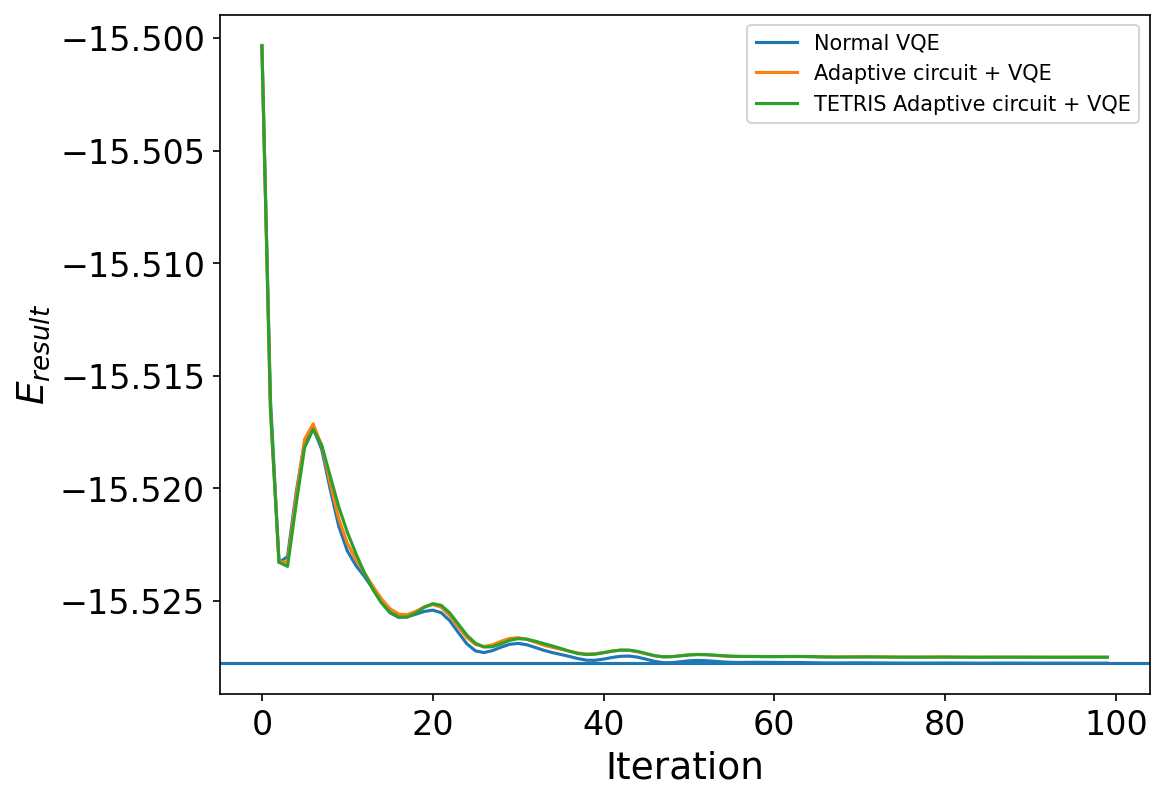

In [ ]:
plt.figure(figsize=(8, 6), dpi=150)
plt.plot(iter, cost_val, label='Normal VQE')
plt.plot(iter, cost_val_a, label='Adaptive circuit + VQE')
plt.plot(iter, cost_val_t, label='TETRIS Adaptive circuit + VQE')
plt.axhline(real_solution_t)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('$E_{result}$', fontsize=18)
plt.xlabel('Iteration', fontsize=18)
plt.legend()
plt.show()

Using the adaptive circuit and TETRIS adaptive circuit, the number of parameters is signficantly reduced by nearly 84.8%. The both circuit depth are reduced about 82.7% and 90.4 % respectively. One may argue that the accuracy of two method is less than the basic vqe. Due to insufficient parameters in the adaptive circuit and TETRIS adaptive circuit, the result cannot be improved as iteration increases. Thus, we need to add the necessary gates to the adaptive circuit so that the result could be improved a lot during the training process.Here, we use the adaptive vqe or TETRIS adaptive vqe to add the necessary gates during training process. 

# Adaptive VQE + adaptive circuit

Here, we reproduce paper's work [3]. Every each iteration, one can add the largest gradient gate to the circuits, and set up the new parameter of the gate zero. Here are following steps [5] how adpative vqe works

1. On the classical device, compute one- and two-body
integrals and transform the fermionic Hamiltonian
to a qubit Hamiltonian using a suitable mapping,
e.g., Jordan-Wigner.
2. On the quantum device, prepare the current ansatz
and measure the energy gradient $∂E/
∂θi
|θi=0$ for every
candidate pool operator $P_i$ with respect to its variational parameter $θ_i$
.
3. If the pool gradient norm is smaller than a predetermined threshold, ADAPT-VQE has converged,
and the algorithm terminates.
4. Add the operator with the largest gradient norm
from step 2 to the ansatz, with its variational parameter set to zero.
5. Perform a VQE subroutine to update all parameters in the current ansatz.
6. Repeat steps 2 – 5 until convergence.

Here, we use the adaptive circuit as the initial ansatz, and train the circuit with adaptive VQE.

[3] https://www.nature.com/articles/s41467-019-10988-2 

[5] https://arxiv.org/abs/2209.10562

In [ ]:
def adapt_vqe_run(r,sol=-15.527759639229922,active_orb=6, num_e=4):
    a0=0.529177210903 #bohr to angstrom
    coordinates=[0.0, 0.0, -r/a0, 0.0, 0.0, 0.0, 0.0,0.0, r/a0]
    charge=0
    hamiltonian = hydrogen_hamiltonian(np.array(coordinates), charge, active_orb=active_orb, num_e=num_e)# step.1

    electrons = num_e
    num_qubits = len(hamiltonian.wires)

    singles, doubles = qml.qchem.excitations(electrons, num_qubits) 
    pool_operators=singles+doubles

    num_qubits = len(hamiltonian.wires)
    hf_state = hf(electrons, num_qubits)
    def circuit_1(params, excitations):
        qml.BasisState(hf_state, wires=range(num_qubits))

        for i, excitation in enumerate(excitations):
            if len(excitation) == 4:
                qml.DoubleExcitation(params[i], wires=excitation)
            else:
                qml.SingleExcitation(params[i], wires=excitation)
        return qml.expval(hamiltonian)

    params = [0.0] * len(doubles)
    params=np.array(params )

    dev = qml.device("default.qubit", wires=num_qubits)
    cost_fn = qml.QNode(circuit_1, dev)
    circuit_gradient = qml.grad(cost_fn, argnum=0)
    grads_d = circuit_gradient(params, excitations=doubles)

    params = [0.0] * len(singles)
    params=np.array(params )

    dev = qml.device("default.qubit", wires=num_qubits)
    cost_fn = qml.QNode(circuit_1, dev)
    circuit_gradient = qml.grad(cost_fn, argnum=0)
    grads_s = circuit_gradient(params, excitations=singles)

    threshold=1e-5
    doubles_select = [(doubles)[i] for i in range(len(doubles)) if abs(grads_d[i]) > threshold] # remove the gate with samller gradient
    singles_select = [(singles)[i] for i in range(len(singles)) if abs(grads_s[i]) > threshold] # remove the gate with samller gradient


    epochs=25
    conv_tol=1e-5
    energy=[]

    operator_circuits=doubles_select+singles_select
    params = [0.0] * len(operator_circuits)
    params=np.array(params )

    opt = qml.GradientDescentOptimizer(stepsize=0.5) 

    dev = qml.device("default.qubit", wires=num_qubits)
    cost_fn = qml.QNode(circuit_1, dev, expansion_strategy="device")
    circuit_gradient = qml.grad(cost_fn, argnum=0)#step.2

    energy = [cost_fn(params, operator_circuits)] # step.2
    print(f"Epoch = 0,  Energy = {energy[-1]:.8f} Ha")
    print("Number of gates = {}\n".format(len(operator_circuits)))
    configs=qml.specs(cost_fn)(params, excitations=operator_circuits)
    print("Circuit Depth = {}\n".format(configs['depth'],))

    for n in range(epochs):
          
        Test_set=operator_circuits+pool_operators
        Test_params=list(params)+[0.0]*len(pool_operators)
        Test_params=np.array(Test_params)

        test_grads = circuit_gradient(Test_params,Test_set)
        test_grads = test_grads[len(params):]
        maxpos = np.argmax(np.abs(test_grads))
        
        max_op=pool_operators[maxpos]   # step.4 for adaptive one
        operator_circuits.append(max_op)# step.4 
        params=np.append(params, 0.0)   # step.4
        
        params,_ = opt.step(cost_fn, params, operator_circuits) # Step 5.
        E_val=cost_fn(params, operator_circuits)
        energy.append(E_val)
        conv = np.abs(sol - E_val) # Step 3. 
        #t2 = time.time()
        print(f"Epoch = {n+1}, Energy = {energy[-1]:.8f} Ha")
        print("Number of gates = {}\n".format(len(operator_circuits)))
        configs=qml.specs(cost_fn)(params, excitations=operator_circuits)
        print("Circuit Depth = {}\n".format(configs['depth'],))
        if conv <= conv_tol:
            break

    return n+1, energy, params, operator_circuits

In [ ]:
r=1.7
iteration_needed_aa, energy_aa, params_aa, operator_circuits_aa=adapt_vqe_run(r)

Epoch = 0,  Energy = -15.47060578 Ha
Number of gates = 14

Circuit Depth = 14

Epoch = 1, Energy = -15.49742667 Ha
Number of gates = 15

Circuit Depth = 15

Epoch = 2, Energy = -15.51269841 Ha
Number of gates = 16

Circuit Depth = 16

Epoch = 3, Energy = -15.52057484 Ha
Number of gates = 17

Circuit Depth = 16

Epoch = 4, Energy = -15.52440330 Ha
Number of gates = 18

Circuit Depth = 17

Epoch = 5, Energy = -15.52609793 Ha
Number of gates = 19

Circuit Depth = 18

Epoch = 6, Energy = -15.52687692 Ha
Number of gates = 20

Circuit Depth = 18

Epoch = 7, Energy = -15.52720951 Ha
Number of gates = 21

Circuit Depth = 19

Epoch = 8, Energy = -15.52735670 Ha
Number of gates = 22

Circuit Depth = 19

Epoch = 9, Energy = -15.52743774 Ha
Number of gates = 23

Circuit Depth = 20

Epoch = 10, Energy = -15.52750378 Ha
Number of gates = 24

Circuit Depth = 20

Epoch = 11, Energy = -15.52756492 Ha
Number of gates = 25

Circuit Depth = 21

Epoch = 12, Energy = -15.52761644 Ha
Number of gates = 26

Ci

# Adaptive VQE + TETRIS adaptive circuit

Here, we use the TETRIS adaptive circuit as the initial ansatz, and train the circuit with adaptive VQE.

[5] https://arxiv.org/abs/2209.10562



In [ ]:
def adapt_vqe_run2(r,sol=-15.527759639229922,active_orb=6,num_e=4):
    a0=0.529177210903
    coordinates=[0.0, 0.0, -r/a0, 0.0, 0.0, 0.0, 0.0, 0.0, r/a0]
    charge=0
    hamiltonian = hydrogen_hamiltonian(np.array(coordinates), charge,active_orb=active_orb, num_e=num_e) #step.1

    electrons = num_e
    num_qubits = len(hamiltonian.wires)

    hf_state = hf(electrons, num_qubits)

    singles, doubles = qml.qchem.excitations(electrons, num_qubits) #generate UCCSD operators
    pool_operators=singles+doubles

    def circuit_1(params, excitations):
        qml.BasisState(hf_state, wires=range(num_qubits))

        for i, excitation in enumerate(excitations):
            if len(excitation) == 4:
                qml.DoubleExcitation(params[i], wires=excitation)
            else:
                qml.SingleExcitation(params[i], wires=excitation)
        return qml.expval(hamiltonian )



    params = [0.0] * len(doubles+singles)
    params=np.array(params )

    dev = qml.device("default.qubit", wires=num_qubits)
    cost_fn = qml.QNode(circuit_1, dev)
    circuit_gradient = qml.grad(cost_fn, argnum=0)
    grads = circuit_gradient(params, excitations=doubles+singles)

    op_pool=doubles+singles
    new_op_pool=[op_pool[idx] for idx in range(len(grads)) if abs(grads[idx]) >1e-5]
    new_grads=[grads[idx] for idx in range(len(grads)) if abs(grads[idx]) > 1e-5]

    dev = qml.device("default.qubit", wires=num_qubits)
    cost_fn = qml.QNode(circuit_1, dev)
    circuit_gradient = qml.grad(cost_fn, argnum=0)
    grads_d = circuit_gradient(params, excitations=doubles)

    params = [0.0] * len(singles)
    params=np.array(params )

    dev = qml.device("default.qubit", wires=num_qubits)
    cost_fn = qml.QNode(circuit_1, dev)
    circuit_gradient = qml.grad(cost_fn, argnum=0)
    grads_s = circuit_gradient(params, excitations=singles)

    threshold=1e-5
    doubles_select = [(doubles)[i] for i in range(len(doubles)) if abs(grads_d[i]) > threshold] # remove the gate with samller gradient
    singles_select = [(singles)[i] for i in range(len(singles)) if abs(grads_s[i]) > threshold] #    


    # create the ansatz with large gradient gates, and stack them well.
    indx=np.argsort(np.abs(new_grads))
    sorted_op_pool=[new_op_pool[idx] for idx in indx]

    operator_circuits=[]     
    while len(sorted_op_pool) !=0:
        q_layer=[]     
        ind_left=[]  
        for idx, op in enumerate(sorted_op_pool):
            if operator_circuits==[]:
                operator_circuits.append(op)
                q_layer=q_layer+op
            else:
                Stack=True
                for k in op:
                    if k in q_layer:
                        Stack=False
                        ind_left.append(idx)
                        break
                if Stack:
                    operator_circuits.append(op)
                    q_layer=q_layer+op
        sorted_op_pool=[sorted_op_pool[idx] for idx in ind_left]

    params = [0.0] * len(doubles_select+singles_select)
    params=np.array(params )

    q_layer=[]
    epochs=25
    conv_tol=1e-5
    energy=[]

    opt = qml.GradientDescentOptimizer(stepsize=0.5) 
    dev = qml.device("default.qubit", wires=num_qubits)

    dev = qml.device("default.qubit", wires=num_qubits)
    cost_fn = qml.QNode(circuit_1, dev, expansion_strategy="device")
    circuit_gradient = qml.grad(cost_fn, argnum=0) #step.2

    energy = [cost_fn(params, operator_circuits)]  #step.2
    print(f"Epoch = 0,  Energy = {energy[-1]:.8f} Ha")
    print("Number of gates = {}\n".format(len(operator_circuits)))
    configs=qml.specs(cost_fn)(params, excitations=operator_circuits)
    print("Circuit Depth = {}\n".format(configs['depth'],))

    for n in range(epochs):

        Test_set=operator_circuits+pool_operators
        Test_params=list(params)+[0.0]*len(pool_operators)
        Test_params=np.array(Test_params)
        
        test_grads = circuit_gradient(Test_params,Test_set)
        test_grads = test_grads[len(params):]

        test_sorted_indx=np.argsort(np.abs(test_grads))[::-1] #get sorted gradient in descending order.

        operator_circuits.append(pool_operators[test_sorted_indx[0]]) #step.4 for adaptive one
        params=np.append(params, 0.0)                                 #step.4

        params,_ = opt.step(cost_fn, params, operator_circuits) # Step 5.
        E_val=cost_fn(params, operator_circuits)
        energy.append(E_val)
        conv = np.abs(sol - E_val) # Step 3. ##-15.594361071247999 6 orbital #-15.56723276 4 orbital
        #t2 = time.time()
        print(f"Epoch = {n+1}, Energy = {energy[-1]:.8f} Ha")
        print("Number of gates = {}\n".format(len(operator_circuits)))
        configs=qml.specs(cost_fn)(params, excitations=operator_circuits)
        print("Circuit Depth = {}\n".format(configs['depth'],))
        if conv <= conv_tol:
            break
    return n+1, energy, params, operator_circuits

In [ ]:
iteration_needed_at, energy_at, params_at, operator_circuits_at=adapt_vqe_run2(r)

Epoch = 0,  Energy = -15.47060578 Ha
Number of gates = 14

Circuit Depth = 8

Epoch = 1, Energy = -15.49742131 Ha
Number of gates = 15

Circuit Depth = 9

Epoch = 2, Energy = -15.51267349 Ha
Number of gates = 16

Circuit Depth = 10

Epoch = 3, Energy = -15.52054134 Ha
Number of gates = 17

Circuit Depth = 10

Epoch = 4, Energy = -15.52437679 Ha
Number of gates = 18

Circuit Depth = 11

Epoch = 5, Energy = -15.52608151 Ha
Number of gates = 19

Circuit Depth = 12

Epoch = 6, Energy = -15.52686867 Ha
Number of gates = 20

Circuit Depth = 12

Epoch = 7, Energy = -15.52720787 Ha
Number of gates = 21

Circuit Depth = 13

Epoch = 8, Energy = -15.52735709 Ha
Number of gates = 22

Circuit Depth = 13

Epoch = 9, Energy = -15.52743873 Ha
Number of gates = 23

Circuit Depth = 14

Epoch = 10, Energy = -15.52750492 Ha
Number of gates = 24

Circuit Depth = 14

Epoch = 11, Energy = -15.52756601 Ha
Number of gates = 25

Circuit Depth = 15

Epoch = 12, Energy = -15.52761739 Ha
Number of gates = 26

Circ

# TETRIS adaptive VQE + TETRIS adaptive circuit

Here we reproduce the paper's work [5]. TETRIS Adaptive VQE is improved version of adaptive vqe. In order to stack the gate well without too many idle qubits (like the plots below), TETRIS adaptive VQE change step 4. of adaptive vqe. Here are new sub steps 4. in TETRIS adaptive VQE

(a) Sort pool operators according to the norms of
their gradients, in descending order.

(b) Identify the operator with the highest gradient norm acting on qubits not acted on by
any previously added operator in the current
ADAPT iteration. Add the operator to the
ansatz, with its variational parameter set to
zero.

(c) If operators that act non-trivially on all qubits
have been added to the ansatz in the current
ADAPT iteration, proceed to step 5.

(d) If the list of operators with nonzero gradients
and disjoint support with operators already
added in the current ADAPT iteration has
been exhausted, proceed to step 5.

(e) Go to sub-step (b).

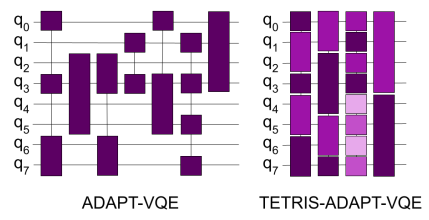

[5] https://arxiv.org/abs/2209.10562

In [ ]:
def TETRIS_adapt_vqe_run(r,cutoff=0.0,paper_ver=True,sol=-15.527759639229922,active_orb=6,num_e=4):
    a0=0.529177210903
    coordinates=[0.0, 0.0, -r/a0, 0.0, 0.0, 0.0, 0.0, 0.0, r/a0]
    charge=0
    hamiltonian = hydrogen_hamiltonian(np.array(coordinates),charge,active_orb=active_orb, num_e=num_e) # step 1

    electrons = num_e
    num_qubits = len(hamiltonian.wires)

    hf_state = hf(electrons, num_qubits)

    singles, doubles = qml.qchem.excitations(electrons, num_qubits) #generate single qubit excitations and double qubit excitations operators.
    pool_operators=singles+doubles

    def circuit_1(params, excitations):
        qml.BasisState(hf_state, wires=range(num_qubits))

        for i, excitation in enumerate(excitations):
            if len(excitation) == 4:
                qml.DoubleExcitation(params[i], wires=excitation)
            else:
                qml.SingleExcitation(params[i], wires=excitation)
        return qml.expval(hamiltonian )


    # create the ansatz with large gradient gates, and stack them well.
    params = [0.0] * len(doubles+singles)
    params=np.array(params )

    dev = qml.device("default.qubit", wires=num_qubits)
    cost_fn = qml.QNode(circuit_1, dev)
    circuit_gradient = qml.grad(cost_fn, argnum=0)
    grads = circuit_gradient(params, excitations=doubles+singles)

    op_pool=doubles+singles
    new_op_pool=[op_pool[idx] for idx in range(len(grads)) if abs(grads[idx]) >1e-5]
    new_grads=[grads[idx] for idx in range(len(grads)) if abs(grads[idx]) > 1e-5]

    dev = qml.device("default.qubit", wires=num_qubits)
    cost_fn = qml.QNode(circuit_1, dev)
    circuit_gradient = qml.grad(cost_fn, argnum=0)
    grads_d = circuit_gradient(params, excitations=doubles)

    params = [0.0] * len(singles)
    params=np.array(params )

    dev = qml.device("default.qubit", wires=num_qubits)
    cost_fn = qml.QNode(circuit_1, dev)
    circuit_gradient = qml.grad(cost_fn, argnum=0)
    grads_s = circuit_gradient(params, excitations=singles)

    threshold=1e-5
    doubles_select = [(doubles)[i] for i in range(len(doubles)) if abs(grads_d[i]) > threshold] # remove the gate with samller gradient
    singles_select = [(singles)[i] for i in range(len(singles)) if abs(grads_s[i]) > threshold] #    

    indx=np.argsort(np.abs(new_grads))
    sorted_op_pool=[new_op_pool[idx] for idx in indx]

    operator_circuits=[]   # the operator here has shallower circuit depth than the adaptive circuit.  
    while len(sorted_op_pool) !=0:
        q_layer=[]     
        ind_left=[]  
        for idx, op in enumerate(sorted_op_pool):
            if operator_circuits==[]:
                operator_circuits.append(op)
                q_layer=q_layer+op
            else:
                Stack=True
                for k in op:
                    if k in q_layer:
                        Stack=False
                        ind_left.append(idx)
                        break
                if Stack:
                    operator_circuits.append(op)
                    q_layer=q_layer+op
        sorted_op_pool=[sorted_op_pool[idx] for idx in ind_left]

    params = [0.0] * len(doubles_select+singles_select)
    params=np.array(params )

    q_layer=[]
    epochs=25
    conv_tol=1e-5
    energy=[]

    opt = qml.GradientDescentOptimizer(stepsize=0.5) 
    dev = qml.device("default.qubit", wires=num_qubits)

    dev = qml.device("default.qubit", wires=num_qubits)
    cost_fn = qml.QNode(circuit_1, dev, expansion_strategy="device")
    circuit_gradient = qml.grad(cost_fn, argnum=0) # step 2.

    energy = [cost_fn(params, operator_circuits)] # step 2.
    print(f"Epoch = 0,  Energy = {energy[-1]:.8f} Ha")
    print("Number of gates = {}\n".format(len(operator_circuits)))
    configs=qml.specs(cost_fn)(params, excitations=operator_circuits)
    print("Circuit Depth = {}\n".format(configs['depth'],))

    for n in range(epochs):

        Test_set=operator_circuits+pool_operators
        Test_params=list(params)+[0.0]*len(pool_operators)
        Test_params=np.array(Test_params)
        
        test_grads = circuit_gradient(Test_params,Test_set)
        test_grads = test_grads[len(params):]

        test_sorted_indx=np.argsort(np.abs(test_grads))[::-1] #get sorted gradient in descending order. # step 4.(a)
        maxpos=test_sorted_indx[0]
        Larger_sorted_indx=[]
        for ind in test_sorted_indx:
            if np.abs(test_grads[ind]) < np.abs(test_grads[maxpos])*cutoff: 
                break
            else:
                Larger_sorted_indx.append(ind)
        # q_layer here is to make sure that selecting operators acting on most of qubits so that there are less idle qubits

        for k,ind in enumerate(Larger_sorted_indx): # Step 4 (b)(c)(d)(e)
            #if k != 0:
            #    break
            op_set=set(pool_operators[ind])
            q_layer_set=set(q_layer)
            if not bool(op_set & q_layer_set):
                q_layer=q_layer+pool_operators[ind]
                operator_circuits.append(pool_operators[ind])
                params=np.append(params, 0.0)
            if (len(q_layer)>=num_qubits-4) and paper_ver: # It is hard to find the operators with non-zero gradient fill all qubit layers.
                q_layer=[]                                 # We leave at maximum 4 idle qubits
                break

        if not  paper_ver: # Since fill the qubit layers is hard, we also try to update q_layer each iteration if one don't want to use paper's step.4 (c)(d)
            q_layer=[]

        params,_ = opt.step(cost_fn, params, operator_circuits) # Step 5.
        E_val=cost_fn(params, operator_circuits)
        energy.append(E_val)
        conv = np.abs(sol - E_val) #step 3.

        print(f"Epoch = {n+1}, Energy = {energy[-1]:.8f} Ha")
        print("Number of gates = {}\n".format(len(operator_circuits)))
        configs=qml.specs(cost_fn)(params, excitations=operator_circuits)
        print("Circuit Depth = {}\n".format(configs['depth'],))
        if conv <= conv_tol:
            break
    return n+1, energy, params, operator_circuits

In [ ]:
iteration_needed_tt, energy_tt, params_tt, operator_circuits_tt=TETRIS_adapt_vqe_run(r)

Epoch = 0,  Energy = -15.47060578 Ha
Number of gates = 14

Circuit Depth = 8

Epoch = 1, Energy = -15.49828954 Ha
Number of gates = 16

Circuit Depth = 9

Epoch = 2, Energy = -15.51475620 Ha
Number of gates = 18

Circuit Depth = 10

Epoch = 3, Energy = -15.52242107 Ha
Number of gates = 20

Circuit Depth = 11

Epoch = 4, Energy = -15.52565156 Ha
Number of gates = 22

Circuit Depth = 12

Epoch = 5, Energy = -15.52677924 Ha
Number of gates = 24

Circuit Depth = 13

Epoch = 6, Energy = -15.52719755 Ha
Number of gates = 26

Circuit Depth = 14

Epoch = 7, Energy = -15.52736752 Ha
Number of gates = 28

Circuit Depth = 15

Epoch = 8, Energy = -15.52747918 Ha
Number of gates = 32

Circuit Depth = 16

Epoch = 9, Energy = -15.52758265 Ha
Number of gates = 36

Circuit Depth = 17

Epoch = 10, Energy = -15.52766213 Ha
Number of gates = 39

Circuit Depth = 18

Epoch = 11, Energy = -15.52771247 Ha
Number of gates = 42

Circuit Depth = 19

Epoch = 12, Energy = -15.52773842 Ha
Number of gates = 45

Circ

In [ ]:
def run_VQE_again(r,conv_tol=1e-04,active_orb=6,num_e=4):
    """Performs a VQE routine for the given hydrogen molecule.

    Args:
        coordinates (list(float)): Cartesian coordinates of each hydrogen molecule.
        charge (int): The electric charge given to the hydrogen molecule.:

    Returns:
        (float): The expectation value of the hydrogen Hamiltonian.
    """
    a0=0.529177210903
    coordinates=[0.0, 0.0, -r/a0, 0.0, 0.0, 0.0, 0.0, 0.0, r/a0]
    charge=0
    hamiltonian = hydrogen_hamiltonian(np.array(coordinates), charge, active_orb=active_orb)

    electrons = num_e
    num_qubits = len(hamiltonian.wires)

    hf_state = hf(electrons, num_qubits)
    # singles and doubles are used to make the AllSinglesDoubles template
    singles, doubles = qml.qchem.excitations(electrons, num_qubits)
    #print("Hamiltonian Length:", len(singles)+len(doubles))
    #print(num_qubits,len(singles))

    dev = qml.device("default.qubit", wires=num_qubits)

    @qml.qnode(dev)
    def cost(weights):
        """A circuit with tunable parameters/weights that measures the expectation value of the hydrogen Hamiltonian.
        
        Args:
            weights (numpy.array): An array of tunable parameters.

        Returns:
            (float): The expectation value of the hydrogen Hamiltonian.
            
        """
        #state=np.array([0]*(num_qubits//2)+[1]*(num_qubits//2))
        qml.BasisState(hf_state, wires=list(range(num_qubits)))
        
        for i in range(len(singles)):
            #for j in range(E_len):
            qml.SingleExcitation(weights[i], wires=singles[i])

        for i in range(len(doubles)):
            qml.DoubleExcitation(weights[i+len(singles)], wires=doubles[i])
        
        return qml.expval(hamiltonian)
    
    weights =np.zeros(len(singles) + len(doubles), requires_grad=True)
    opt = qml.AdamOptimizer(0.5)

    iter=[]
    cost_val=[]
    for i in range(100):
        weights = opt.step(cost, weights)
        iter.append(i)
        e=cost(weights)
        conv = np.abs(np.real(real_solution_t) - e)

        configs=qml.specs(cost)(weights)
        print(i, e)
        cost_val.append(e)
        if conv <= conv_tol:
            break


    return i+1, cost_val, weights, singles+doubles

In [ ]:
iteration_needed, energy, params, operator_circuits=run_VQE_again(r,conv_tol=1e-05)

0 -15.053129346930517
1 -15.371235288723657
2 -15.460717891578755
3 -15.302615484550373
4 -15.350726026517744
5 -15.470791651068968
6 -15.480743494040993
7 -15.42829394014491
8 -15.416458304973094
9 -15.460085692203398
10 -15.500164788202367
11 -15.489725194745764
12 -15.466180355878173
13 -15.471020025209443
14 -15.49695269423783
15 -15.509529452089643
16 -15.498686681511817
17 -15.489433790260499
18 -15.497418976955599
19 -15.51162489153853
20 -15.515814815842893
21 -15.509454378604143
22 -15.504632367062658
23 -15.509213251779698
24 -15.51827016635917
25 -15.521336864489657
26 -15.516336556811382
27 -15.512365989114674
28 -15.516592961933538
29 -15.523506874810682
30 -15.523722015406582
31 -15.519182093782023
32 -15.518394890206665
33 -15.522479643787262
34 -15.525289815317917
35 -15.523791962186944
36 -15.522005032694667
37 -15.52333351822816
38 -15.525377128727618
39 -15.525270671511498
40 -15.524339015053636
41 -15.524902419645347
42 -15.526013791972922
43 -15.525807760755132
44 

# Comparison

In [ ]:
def count_num_gates(excitations):
    cnot_num=0
    num_gates=0+4 #preparing the Hatree fock state initially

    for i, excitation in enumerate(excitations):
        if len(excitation) == 4:
            cnot_num=cnot_num+10
            num_gates=num_gates+34
        else:
            cnot_num=cnot_num+2
            num_gates=num_gates+13
    return cnot_num, num_gates

num_qubits=12
print("In order to get result with error within 1e-5")
print("Adaptive vqe + adaptive circuit needs ",iteration_needed_aa, " iterations")
print("Adaptive vqe + TETRIS adaptive circuit needs ",iteration_needed_at, " iterations")
print("TETRIS adaptive vqe + TETRIS adaptive circuit needs ",iteration_needed_tt, " iterations")
print("Orginal vqe needs ", iteration_needed, "iterations")

dev = qml.device("default.qubit", wires=num_qubits)
specs_func = qml.specs(circuit_1)
print(" ")
print("Adaptive vqe + adaptive circuit depth:",specs_func(params_aa, operator_circuits_aa)['depth'])
print("Adaptive vqe + TETRIS adaptive circuit depth:",specs_func(params_at, operator_circuits_at)['depth'])
print("TETRIS adaptive vqe + TETRIS adaptive circuit depth:",specs_func(params_tt, operator_circuits_tt)['depth'])
print("VQE circuit depth:",specs_func(params, operator_circuits)['depth'])
print(" ")

cnot_num_aa, num_gates_aa=count_num_gates(operator_circuits_aa)
cnot_num_at, num_gates_at=count_num_gates(operator_circuits_at)
cnot_num_tt, num_gates_tt=count_num_gates(operator_circuits_tt)
cnot_num, num_gates=count_num_gates(operator_circuits)
print("Adaptive vqe + adaptive needs ",cnot_num_aa,' cnot gates and',num_gates_aa,'gates')
print("Adaptive vqe + TETRIS adaptive circuit needs ",cnot_num_at,' cnot gates and',num_gates_at,'gates')
print("TETRIS adaptive vqe + TETRIS adaptive circuit needs ",cnot_num_tt,' cnot gates and',num_gates_tt,'gates')
print("Basic vqe needs ",cnot_num,' cnot gates and',num_gates,'gates')

In order to get result with error within 1e-5
Adaptive vqe + adaptive circuit needs  19  iterations
Adaptive vqe + TETRIS adaptive circuit needs  19  iterations
TETRIS adaptive vqe + TETRIS adaptive circuit needs  13  iterations
Orginal vqe needs  91 iterations
 
Adaptive vqe + adaptive circuit depth: 431
Adaptive vqe + TETRIS adaptive circuit depth: 313
TETRIS adaptive vqe + TETRIS adaptive circuit depth: 389
VQE circuit depth: 1536
 
Adaptive vqe + adaptive needs  258  cnot gates and 937 gates
Adaptive vqe + TETRIS adaptive circuit needs  258  cnot gates and 937 gates
TETRIS adaptive vqe + TETRIS adaptive circuit needs  358  cnot gates and 1308 gates
Basic vqe needs  792  cnot gates and 2796 gates


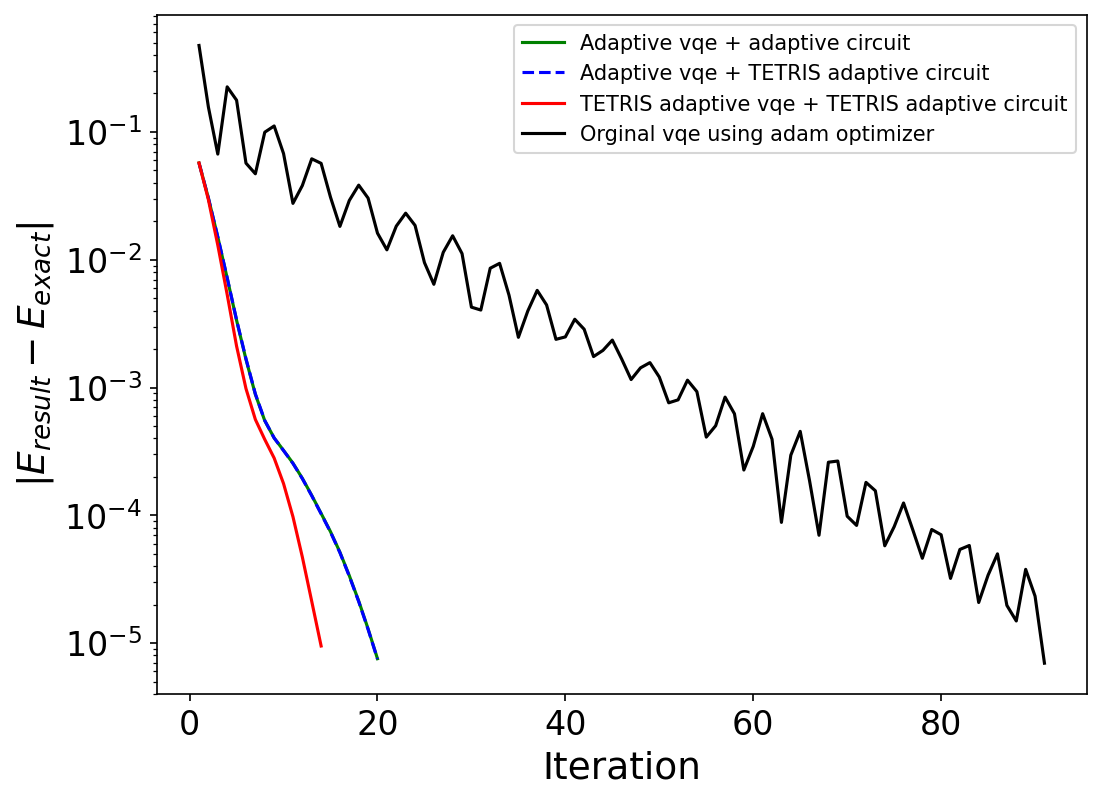

In [ ]:
plt.figure(figsize=(8, 6), dpi=150)
iteration_needed_tt_lst=[i+1 for i in range(iteration_needed_tt+1)]
iteration_needed_at_lst=[i+1 for i in range(iteration_needed_at+1)]
iteration_needed_aa_lst=[i+1 for i in range(iteration_needed_aa+1)]
iteration_needed_lst=[i+1 for i in range(iteration_needed)]
plt.plot(iteration_needed_aa_lst, np.array(energy_aa)-real_solution_t, 'g-', label='Adaptive vqe + adaptive circuit')
plt.plot(iteration_needed_at_lst, np.array(energy_at)-real_solution_t, 'b--', label='Adaptive vqe + TETRIS adaptive circuit')
plt.plot(iteration_needed_tt_lst, np.array(energy_tt)-real_solution_t, 'r', label='TETRIS adaptive vqe + TETRIS adaptive circuit')
plt.plot(iteration_needed_lst, np.array(energy)-real_solution_t, 'k', label='Orginal vqe using adam optimizer')
plt.yscale('log')
plt.ylabel('$|E_{result}-E_{exact}|$', fontsize=18)
plt.xlabel('Iteration', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()
plt.show()

Using the adaptive vqe + adaptive circuit, we just used 937 gates and 258 cnot gates to get the result with error less than 1e-5. But its circuit depth is 431. Adaptive vqe + TETRIS adaptive circuit also needs 937 gates and 258 cnot gates to get the result with error less 1e-5. Its circuit depth is just 313. Although TETRIS adaptive vqe + TETRIS adaptive circuit require more gates, it just spend 13 iterations to obtain the result with error less than 1e-5. Adaptive vqe + adaptive circuit and Adaptive vqe + TETRIS adaptive circuit take 19 iteration to get the error below 1e-5. Compared with the result basic vqe, all of three methods significantly reduce the number of gates, circuit depth, and have better converge. 

# The bond length vs ground state energy
(12 qubits require amount of time for qiskit to get exact solution)

In [ ]:
from qiskit.algorithms import NumPyMinimumEigensolver
def get_sol_from_qiskit(r,active_orb=6,num_electrons=4,parity=False):
    hydrogen_t = [["H", [-r, 0.0, 0.0]], 
                  ["Be", [0.0, 0.0, 0.0]], 
                  ["H", [r, 0.0, 0.0]]]
                      
    h3p = Molecule(
        geometry=  hydrogen_t,
        multiplicity=1, 
        charge=0, 
    )

    driver = ElectronicStructureMoleculeDriver(h3p, basis="sto-3g", driver_type=ElectronicStructureDriverType.PYSCF) 

    properties = driver.run()
    PN_property = properties.get_property("ParticleNumber")

    # Define the active space around the Fermi level 
    # (selected automatically around the HOMO and LUMO, ordered by energy)
    transformer = ActiveSpaceTransformer(
        num_electrons=num_electrons, #how many electrons we have in our active space
        num_molecular_orbitals=active_orb, #how many orbitals we have in our active space
    )

    # Now you can get the reduced electronic structure problem
    problem_reduced = ElectronicStructureProblem(driver, transformers=[transformer]) 

    # The second quantized Hamiltonian of the reduce problem
    second_q_ops_reduced = problem_reduced.second_q_ops()
    if parity !=True:
        mapper = JordanWignerMapper()

        converter = QubitConverter(mapper)

        qubit_op = converter.convert(second_q_ops_reduced["ElectronicEnergy"])

    else:
        parity_mapper = ParityMapper()
        # Set the qubit converter with two qubit reduction to reduce the computational cost 
        parity_converter = QubitConverter(parity_mapper, two_qubit_reduction=True)    

        # Compute the Hamitonian in qubit form
        qubit_op_parity = parity_converter.convert(second_q_ops_reduced.get('ElectronicEnergy'), num_particles=problem_reduced.num_particles)

    
    vqe_factory = VQEUCCFactory( # This is an example of UCC"SD" ansatz
    quantum_instance=Aer.get_backend("aer_simulator_statevector"),
    optimizer=SLSQP(),
    ansatz=UCC(excitations='sd')
    ) 

    numpy_solver = NumPyMinimumEigensolver()
    if parity==True:
        solver = GroundStateEigensolver(parity_converter, vqe_factory)  
        real_solution_t = solver.solve(problem_reduced).total_energies[0]
    else:
        solver = GroundStateEigensolver(converter, vqe_factory)  
        real_solution_t = solver.solve(problem_reduced).total_energies[0]
    return  real_solution_t

Takes 25 mins

In [ ]:
#r_lst=[i*0.2+0.8 for i in range(9)]
#TT_result=[]
#for r_s in r_lst:  
#    _, energy_tt, _, _=TETRIS_adapt_vqe_run(r_s,cutoff=0.9,paper_ver=False)
#    TT_result.append(energy_tt[-1])

Takes 26 mins

In [ ]:
#AA_result=[]
#for r_s in r_lst:
#    _, energy_aa, _, _=adapt_vqe_run(r_s)
#    AA_result.append(energy_aa[-1])

Takes 26 mins

In [ ]:
#AT_result=[]
#for r_s in r_lst:
#    _, energy_at, _, _=adapt_vqe_run2(r_s)
#    AT_result.append(energy_at[-1])

36 mins to run

In [ ]:
#result=[]
#for r_s in r_lst:
#    _, energy, _, _=run_VQE_again(r_s)
#    result.append(energy[-1])


1 hours to run

In [ ]:
#exact=[]
#for r_s in r_lst:
#    exact.append(get_sol_from_qiskit(r_s))

In [52]:
TT_result=[-15.17215239,-15.48116611,-15.58318749,-15.58996389,-15.55353054,-15.49979572,-15.44297443,
          -15.39187758-15.35297833]

exact=[-15.172167498683134,-15.481168435226788,
 -15.583189689928377,-15.589966052930187,
 15.553531685130919,-15.499789631936995,
 -15.442935856112399,-15.39177943788372,
 -15.353093171812835]

result=[-15.1721145,-15.48114261,-15.58316874,-15.58996337,-15.55352461,-15.49978208,-15.44292505,-15.39175577,-15.35304005]

AA_result=[-15.17215245,-15.48116611,-15.5831875,-15.5899639,-15.55353048,-15.49979478,
 -15.44296086,-15.3918006,-15.35254853]

AT_result=[-15.17215243,-15.48116611,-15.58318749,-15.58996387,-15.55353038,-15.49979443,
          -15.44296093,-15.39180942,-15.35260423]

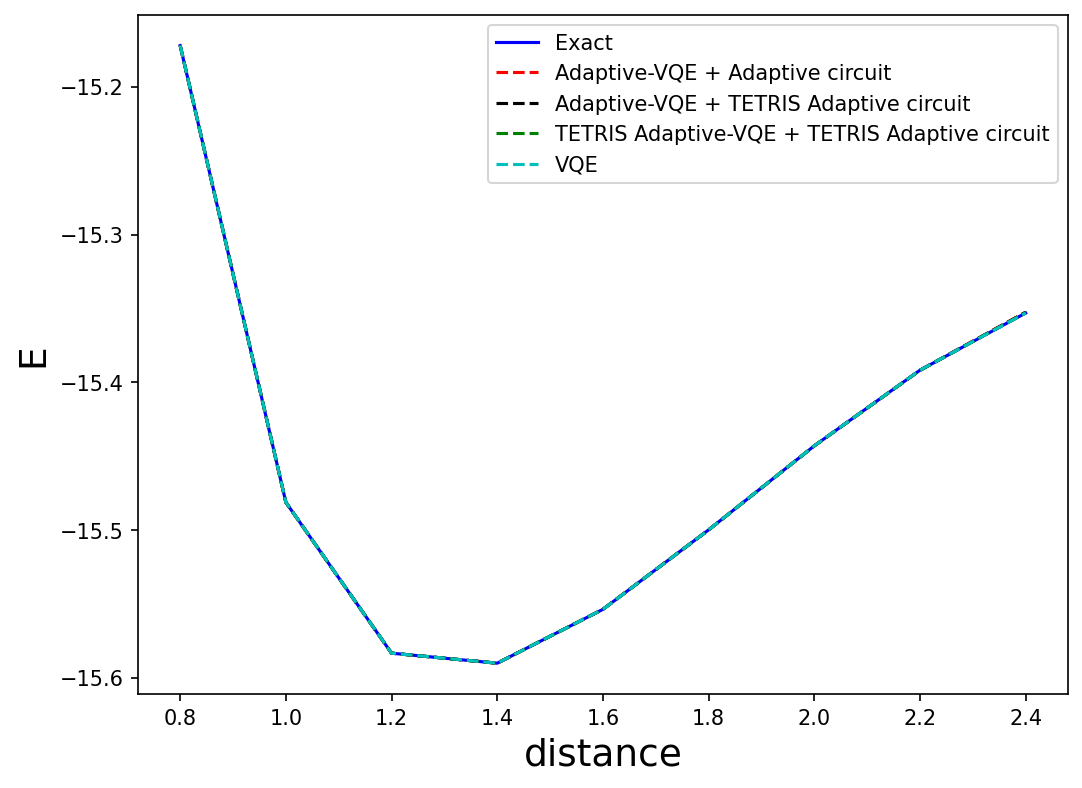

In [ ]:
r_lst=[i*0.2+0.8 for i in range(9)]
plt.figure(figsize=(8, 6), dpi=150)
plt.plot(r_lst,exact,'b', label='Exact')
plt.plot(r_lst,AA_result,'r--', label='Adaptive-VQE + Adaptive circuit')
plt.plot(r_lst,AT_result,'k--', label='Adaptive-VQE + TETRIS Adaptive circuit')
plt.plot(r_lst,TT_result,'g--', label='TETRIS Adaptive-VQE + TETRIS Adaptive circuit')
plt.plot(r_lst,result,'c--', label='VQE')
plt.legend()
plt.ylabel('E', fontsize=18)
plt.xlabel('distance', fontsize=18)
plt.show()

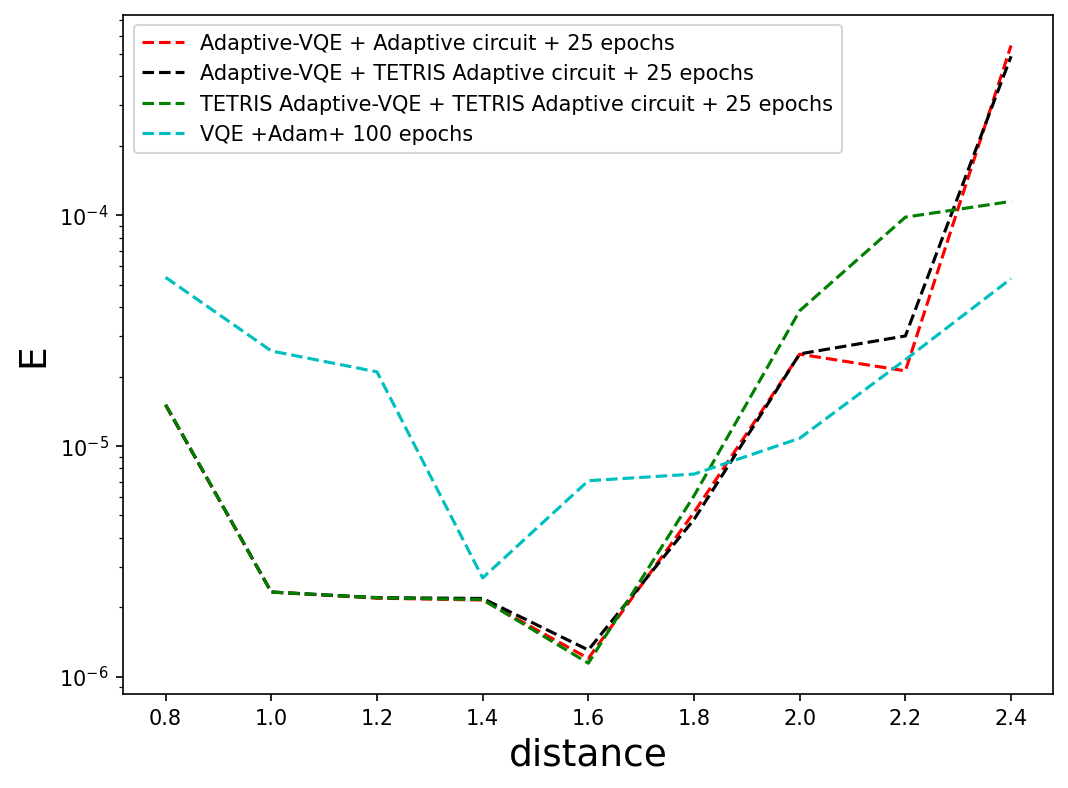

In [ ]:
#plt.plot(r_lst,exact,'b', label='Exact')
plt.figure(figsize=(8, 6), dpi=150)
plt.plot(r_lst,np.abs(np.array(exact)-np.array(AA_result)),'r--', label='Adaptive-VQE + Adaptive circuit + 25 epochs')
plt.plot(r_lst,np.abs(np.array(exact)-np.array(AT_result)),'k--', label='Adaptive-VQE + TETRIS Adaptive circuit + 25 epochs')
plt.plot(r_lst,np.abs(np.array(exact)-np.array(TT_result)),'g--', label='TETRIS Adaptive-VQE + TETRIS Adaptive circuit + 25 epochs')
plt.plot(r_lst,np.abs(np.array(exact)-np.array(result)),'c--', label='VQE +Adam+ 100 epochs')
plt.legend()
plt.yscale('log')
plt.ylabel('E', fontsize=18)
plt.xlabel('distance', fontsize=18)
plt.show()

When bond length is between 0.8 and 1.8 angstrom, with only 25 iterations, both of ADAPT vqe and TETRIS-ADAPT vqe work well and reach the result with error within 1e-5.However, when bond length is larger than 1.8 angstrom. The accuracy of the result from ADAPT vqe and TETRIS-ADAPT vqe becomes worse. There are two solution could make result better. The stepsize of optimizer could be tuned larger. One could also run more iteration and see whether the result is improve or not.